In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)
library(grid)

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


In [4]:
empo3_dir = '/home/ben/Data/empo_3/'

In [5]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [6]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [7]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')

In [8]:
prf = prf.join(abundances, ['sample type', 'sample'])

In [9]:
folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])

In [10]:
prf = prf[prf['method'] == 'weighted']
level7 = prf[(prf['level'] == 7) | (prf['level'] == 6)]
level7 = level7[(level7['class weights'] == 'average') |
                (level7['class weights'] == 'bespoke70') |
                (level7['class weights'] == 'uniform70')]

In [11]:
level7.head()

,Unnamed: 0,F-measure,Precision,Recall,Unnamed: 0.1,class weights,level,method,sample,sample type,abundance,fold
210761,210761,0.720419,0.726283,0.714648,5.0,average,6,weighted,10798.AC.B.4C.2016.42723,animal-corpus,12234,3
210762,210762,0.714835,0.722626,0.707209,6.0,average,7,weighted,10798.AC.B.4C.2016.42723,animal-corpus,12234,3
210775,210775,0.884587,0.928407,0.844718,5.0,average,6,weighted,10798.MC.B.1D.2016.42723,animal-corpus,27157,4
210776,210776,0.841275,0.906154,0.785065,6.0,average,7,weighted,10798.MC.B.1D.2016.42723,animal-corpus,27157,4
210789,210789,0.876521,0.939947,0.821114,5.0,average,6,weighted,1064.G.CV239.27125,animal-corpus,13858,2


In [12]:
grouped = level7.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [13]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new
for old, new in zip((6, 7), ('Genus', 'Species')):
    figure1.loc[figure1['level'] == old, 'level'] = new

In [21]:
%%R -i figure1
figure1$sample.type = factor(figure1$sample.type, levels=c(
 'Water (saline)',
 'Surface (saline)',
 'Sediment (saline)',
 'Water (non-saline)',
 'Surface (non-saline)',
 'Soil (non-saline)',
 'Sediment (non-saline)',
 'Plant rhizosphere',
 'Plant corpus',
 'Animal surface',
 'Animal secretion',
 'Animal proximal gut',
 'Animal distal gut',
 'Animal corpus'))
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Uniform', 'Average', 'Bespoke'
))
figure1$fill <- paste(figure1$level, figure1$class.weights)
figure1$fill <- factor(figure1$fill, levels=c(
  'Species Uniform',
  'Species Average',
  'Species Bespoke',
  'Genus Uniform',
  'Genus Average',
  'Genus Bespoke'))
fillPalette <- c("#56B4E9", "#009E73", "#E69F00", "#D4ECF9", "#BFE6DC", "#F8E7BF")
colourPalette <- c("#56B4E9", "#009E73", "#E69F00", "#56B4E9", "#009E73", "#E69F00")
p <- ggplot(data=figure1, aes(x=sample.type, y=mean)) +
  geom_boxplot(data=figure1[figure1$level == 'Species',], lwd=0.2, outlier.size=0.2, position=position_dodge(width=0.9),
           aes(fill=fill)) +
  geom_boxplot(data=figure1[figure1$level == 'Genus',], lwd=0.2, outlier.size=0.2, position=position_dodge(width=0.9),
           aes(fill=fill)) +
  coord_flip(clip="off") + 
  theme_bw() +
  labs(x='EMPO3 Habitat', y='F-measure') +
  scale_fill_manual(name='Level & Weights', values=fillPalette) +
  scale_colour_manual(name='Level & Weights', values=colourPalette) +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"),
        axis.text.y = element_text(angle = 45)) +
  annotation_custom(
    grob=grid::textGrob(label = "Better Performance"),
    xmin=-0.5, xmax=-0.5, ymin=0.82, ymax=0.82
  ) + 
  annotation_custom(
    grob=linesGrob(arrow=arrow(type="open", ends="last", length=unit(2,"mm"))), 
    xmin=-0.3, xmax=-0.3, ymin=0.7, ymax=0.95
  ) 

ggsave(file="sr-f-measure.png", width=5, height=10, dpi=300)

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


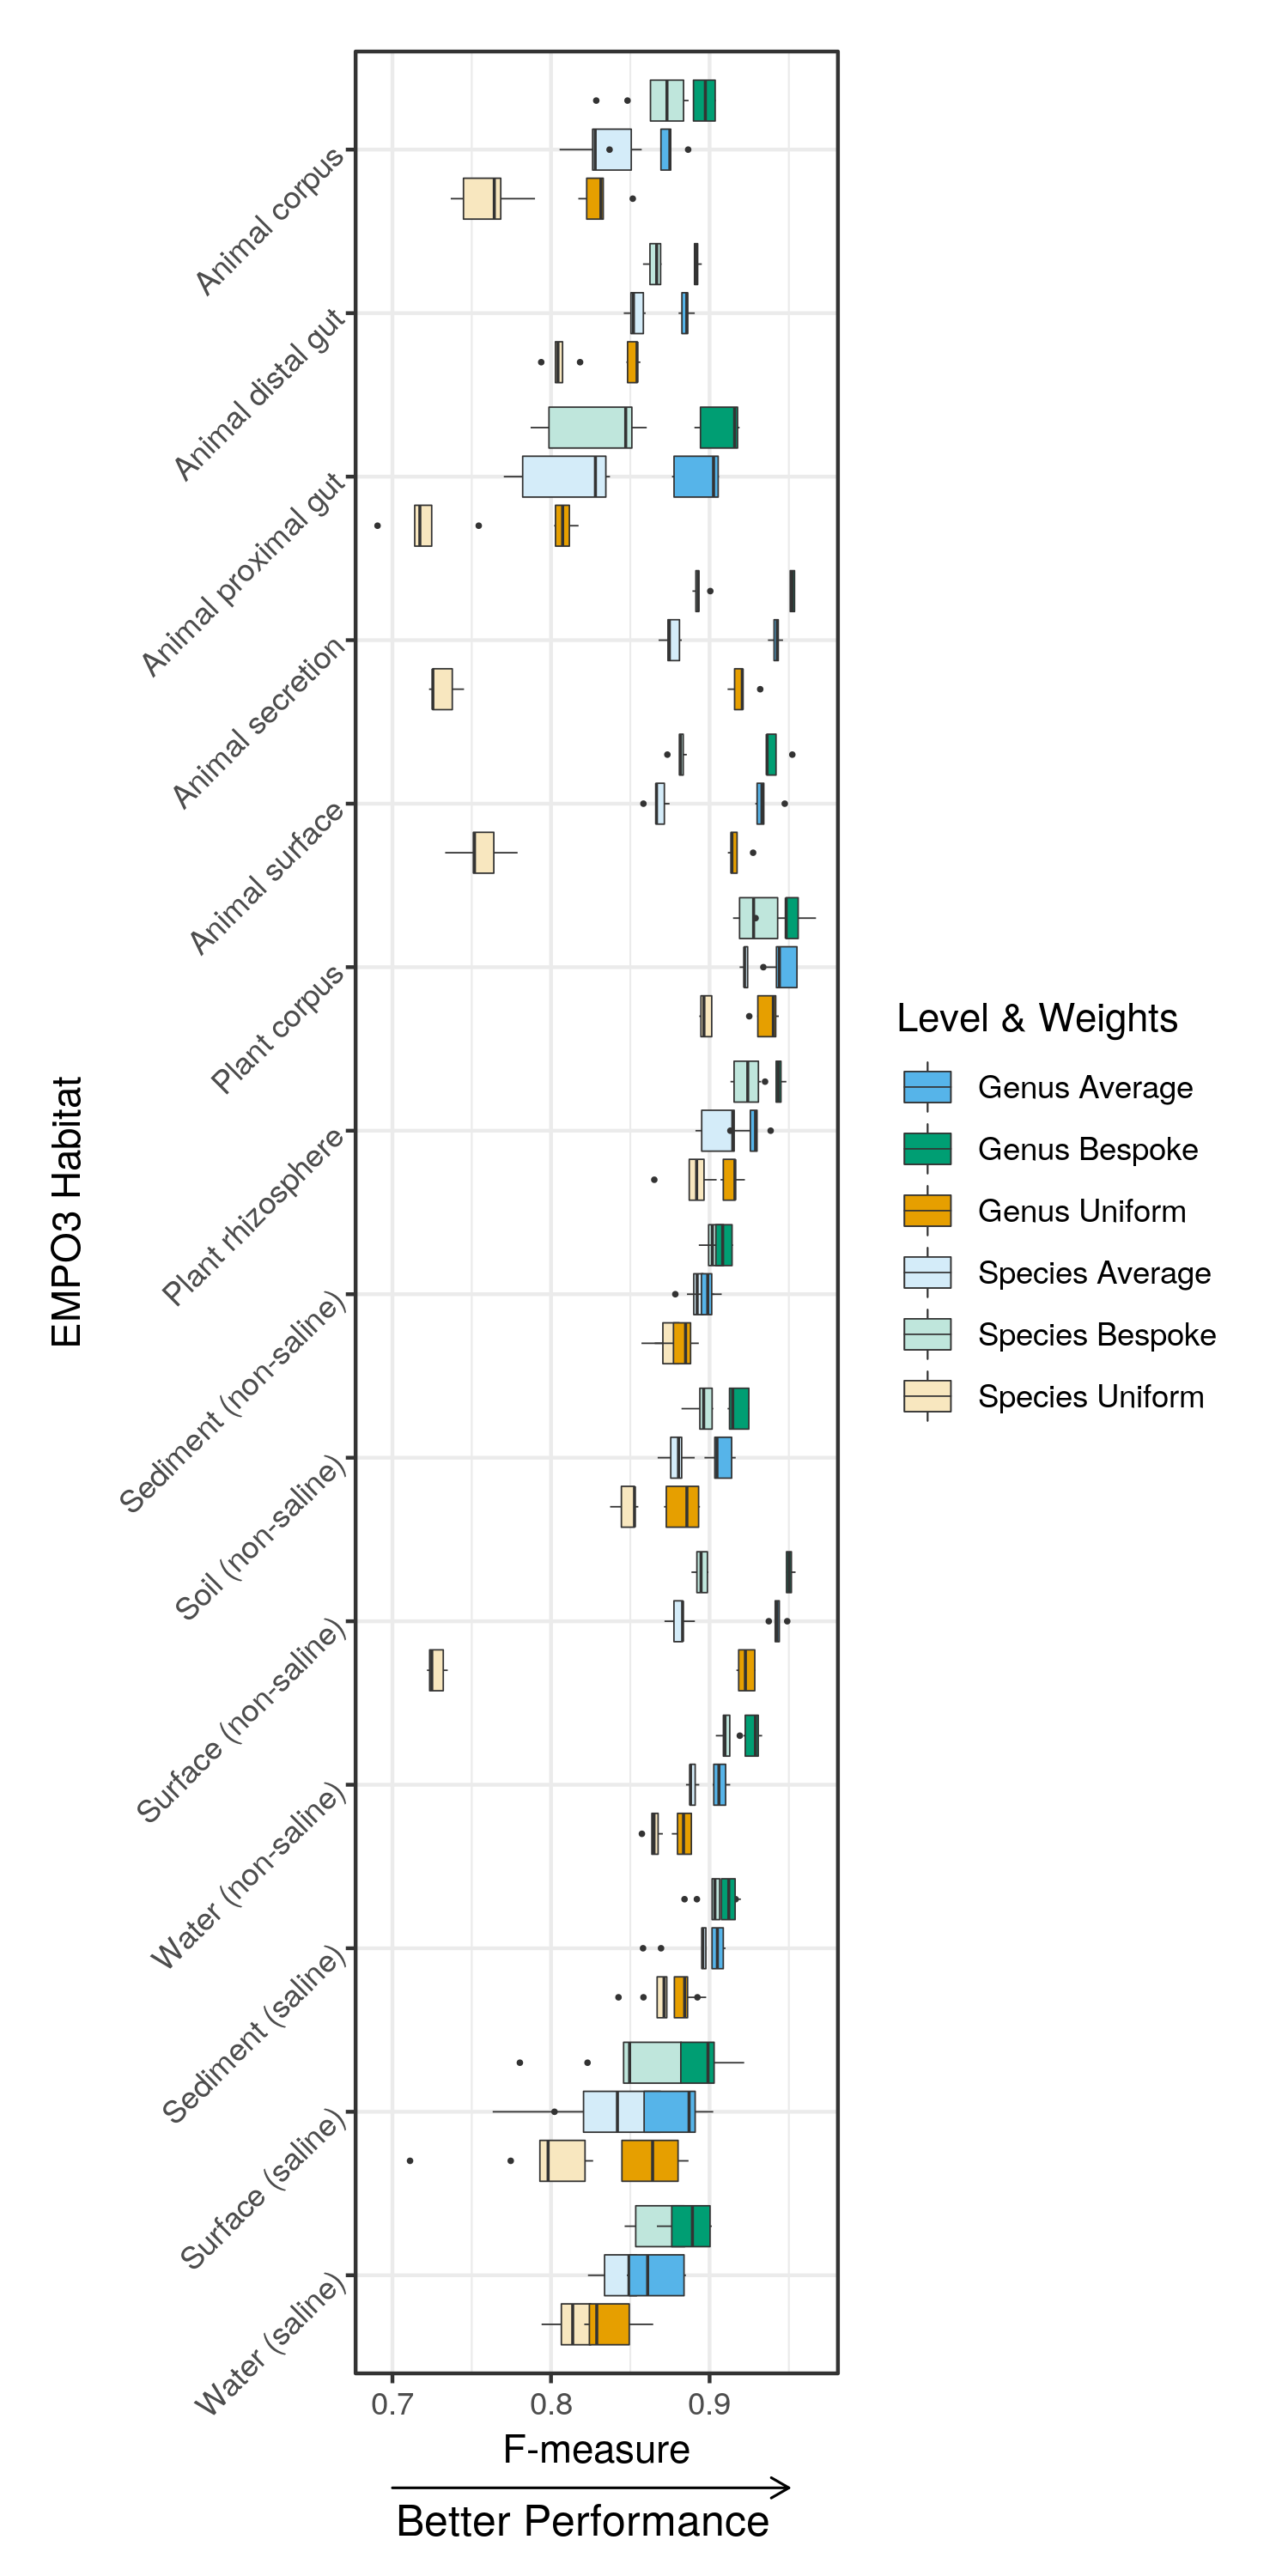

In [22]:
Image("sr-f-measure.png")

In [16]:
max(figure1['upper'] - figure1['lower'])

0.13128721225598428

In [17]:
bespoke = figure1[figure1['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure1[figure1['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.8288638081095409 0.9305880832502146
0.720229783917639 0.9021711163046009


In [18]:
len(set(level7['sample']))

21513

In [19]:
list(set(level7['sample']))[:10]

['11113.907.36782',
 '2192.H01a.Bedroom.Floor.268.lane2.NoIndex.L002.30619',
 '550.L6S38.s.6.sequence.30395',
 '550.L4S155.s.4.sequence.30395',
 '11113.686.36782',
 '11444.H4.fecal.none.1wk.43342',
 '10308.Fh.P4.IFF.B.10.30930',
 '1883.2005.21.Crump.Artic.LTREB.main.lane4.NoIndex.30612',
 '1024.SH004.C1.RH.1.161.flw.6.11.G1.L00.28362',
 '550.L4S165.s.4.sequence.30395']

In [20]:
len(set(_id.split('.')[1] for _id in level7['sample']))

7204

In [21]:
len(set(_id.split('.')[1] for _id in level7[level7['sample type']=='surface-saline']['sample']))

58

In [35]:
grouped = level7.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['Recall'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
grouped = precision.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
precision[(precision['class weights'] == 'bespoke70') | 
          (precision['class weights'] == 'uniform70')]

,sample type,class weights,mean,lower,upper
5,animal-corpus,bespoke70,0.834079,0.807420,0.860737
13,animal-corpus,uniform70,0.696828,0.671568,0.722089
21,animal-distal-gut,bespoke70,0.836902,0.830967,0.842838
29,animal-distal-gut,uniform70,0.761069,0.746696,0.775442
37,animal-proximal-gut,bespoke70,0.787296,0.752892,0.821699
45,animal-proximal-gut,uniform70,0.650310,0.628537,0.672082
53,animal-secretion,bespoke70,0.854664,0.851688,0.857641
61,animal-secretion,uniform70,0.639334,0.629122,0.649546
69,animal-surface,bespoke70,0.838421,0.831812,0.845030
77,animal-surface,uniform70,0.669983,0.647305,0.692661
